In [10]:
#import required modules
from bs4 import BeautifulSoup # library to scrape information from web pages
import urllib.request # library to open URLs
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import requests # library to handle requests
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import geodesic # calculate gedesic distance between two points
import numpy as np # library to handle data in a vectorized manner
from sklearn.cluster import KMeans # import k-means from clustering stage
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors
pd.set_option('display.max_colwidth', None)

In [74]:
with open('foursq_credentials.json') as json_data:
    fsq_cred = json.load(json_data)

VERSION = '20180605' # Foursquare API version
LIMIT = 100

headers = ['S.No.', 'Location', 'Pincode']

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            fsq_cred['CLIENT_ID'], 
            fsq_cred['CLIENT_SECRET'], 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [4]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [84]:
def create_map(neighborhoods, zoom = 10, cluster_info = False, address=None):
    
    if address == None:
        # create map of Bangalore using latitude and longitude values
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode('Bangalore, India')
        latitude = location.latitude
        longitude = location.longitude
    else:
        location = get_location(address)
        latitude = location.latitude
        longitude = location.longitude

    map_neighborhoods = folium.Map(location=[latitude, longitude], zoom_start=zoom)
    
    if cluster_info:
        
        # set color scheme for the clusters
        x = np.arange(kclusters)
        ys = [i + x + (i*x)**2 for i in range(kclusters)]
        colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]

        # add markers to the map
        markers_colors = []
        for lat, lon, poi, cluster in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Location'], neighborhoods['Cluster Labels']):
            label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
            folium.CircleMarker(
                [lat, lon],
                radius=5,
                popup=label,
                color=rainbow[int(cluster)-1],
                fill=True,
                fill_color=rainbow[int(cluster)-1],
                fill_opacity=0.7).add_to(map_neighborhoods)
    
    else:
        
        # add markers to map
        for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Location']):
            label = '{}, {}'.format(neighborhood, 'Bangalore')
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [float(lat), float(lng)],
                radius=5,
                popup=label,
                color='blue',
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(map_neighborhoods)

    return map_neighborhoods    

In [29]:
def get_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    return location

In [72]:
def read_url_data(url):
    # Make a GET request to fetch the raw HTML content
    html_content = requests.get(url).text

    # Parse the html content
    soup = BeautifulSoup(html_content, "lxml")
    #print(soup.prettify()) # print the parsed data of html

    table = soup.find_all("table", attrs={"class": "table table-bordered"})
    table_data = table[1].find_all("tr")  # contains 2 rows

    # Get all the rows of table
    data = []
    for tr in table_data: # find all tr's from table's tbody
        t_row = {}
        for td, th in zip(tr.find_all("td"), headers[1:]): 
            t_row[th] = td.text.replace('\n', '').strip()
        data.append(t_row)
        
    return data

In [75]:
# Enter the URL to read
url='https://indiamapia.com/Bangalore.html'
    
#bangalore_pincode_df.to_csv("Bangalore_pincode.csv", index=False)
bangalore_pincode_df = pd.DataFrame(read_url_data(url)).reset_index().rename(columns={'index':headers[0]}).astype({headers[0]:'object'})
bangalore_pincode_df.head()

,S.No.,Location,Pincode
0,0,A F Station Yelahanka,560063
1,1,Adugodi,560030
2,2,Agara,560034
3,3,Agram,560007
4,4,Air Force Hospital,560007


In [11]:
latlon_info = pd.DataFrame(columns = ['S.No.', 'Location', 'Latitude', 'Longitude'])

for loc in bangalore_pincode_df['Location'].dropna():
    #print (loc + ', Chennai') #loc + ', Bangalore'
    address = loc + ', Bangalore'
    location = get_location(address)
    if location == None:
        continue
    latitude = location.latitude
    longitude = location.longitude
    
    val = {'S.No.':bangalore_pincode_df.loc[bangalore_pincode_df['Location'] == loc, 'S.No.'].to_list()[0],
       'Location':loc,
       'Latitude':latitude,
       'Longitude':longitude
      }
    latlon_info = latlon_info.append(val, ignore_index=True)
    
    print('The geograpical coordinate of {}, Bangalore are {}, {}.'.format(loc, latitude, longitude))
    
#bangalore_data = bangalore_pincode_df.merge(latlon_info[['S.No.', 'Latitude', 'Longitude']], on='S.No.', how='left')
#bangalore_data.to_csv('bangalore_data.csv', index=False)
#bangalore_data.index.name = None
latlon_info.head()

The geograpical coordinate of Adugodi, Bangalore are 12.9428472, 77.6104155.
The geograpical coordinate of Agara, Bangalore are 12.6201123, 77.4793074.
The geograpical coordinate of Amruthahalli, Bangalore are 13.0665131, 77.5966238.
The geograpical coordinate of Anandnagar, Bangalore are 13.033377, 77.5895227.
The geograpical coordinate of Anekal, Bangalore are 12.799122, 77.68060437921741.
The geograpical coordinate of Arabic College, Bangalore are 13.0300088, 77.6208657.
The geograpical coordinate of Aranya Bhavan, Bangalore are 13.01061485, 77.57081951019086.
The geograpical coordinate of Ashoknagar, Bangalore are 12.9791198, 77.5912997.
The geograpical coordinate of Attibele, Bangalore are 12.7782588, 77.7712834.
The geograpical coordinate of Attur, Bangalore are 13.0994536, 77.5680336.
The geograpical coordinate of Austin Town, Bangalore are 12.9612736, 77.6152935.
The geograpical coordinate of Avalahalli, Bangalore are 13.0352777, 77.7365655.
The geograpical coordinate of Avenue

The geograpical coordinate of Kendriya Vihar, Bangalore are 13.1067289, 77.59970299116564.
The geograpical coordinate of Kodigehalli, Bangalore are 13.3352382, 77.6378555.
The geograpical coordinate of Konanakunte, Bangalore are 12.8792861, 77.5697529.
The geograpical coordinate of Koramangala, Bangalore are 13.2923988, 77.7519261.
The geograpical coordinate of Koramangala I Block, Bangalore are 12.928080600000001, 77.63071968728623.
The geograpical coordinate of Koramangala VI Bk, Bangalore are 13.2923988, 77.7519261.
The geograpical coordinate of Kothanur, Bangalore are 13.0613601, 77.6493895.
The geograpical coordinate of Krishnarajapuram, Bangalore are 13.0005089, 77.6753945.
The geograpical coordinate of Krishnarajapuram R S, Bangalore are 13.0005089, 77.6753945.
The geograpical coordinate of Kumaraswamy Layout, Bangalore are 12.9081487, 77.5553179.
The geograpical coordinate of Kundalahalli, Bangalore are 12.9684441, 77.7187843.
The geograpical coordinate of Lalbagh West, Bangalo

,S.No.,Location,Latitude,Longitude
0,1,Adugodi,12.942847,77.610416
1,2,Agara,12.620112,77.479307
2,5,Amruthahalli,13.066513,77.596624
3,6,Anandnagar,13.033377,77.589523
4,7,Anekal,12.799122,77.680604


In [ ]:
#loc1 = bangalore_data.dropna().groupby(['Latitude', 'Longitude'])['Location'].apply(lambda x: ",".join(x)).reset_index()
#bangalore_data_unique1 = bangalore_data.dropna()[['Pincode', 'Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).first().reset_index()
#bangalore = pd.concat([bangalore_data_unique1, loc1['Location']], axis=1)
#bangalore
#bangalore_pincode_df.merge(latlon_info[['S.No.', 'Latitude', 'Longitude']], on='S.No.', how='left').dropna().groupby(['Latitude']).nunique()

In [47]:
bangalore = bangalore_pincode_df.merge(latlon_info[['S.No.', 'Latitude', 'Longitude']], on='S.No.', how='left').dropna()
bangalore.to_csv('bangalore.csv',index=False)
    
map_bangalore = create_map(bangalore, 11)
map_bangalore

In [32]:
bangalore_venues = getNearbyVenues(names=bangalore['Location'],
                                   latitudes=bangalore['Latitude'],
                                   longitudes=bangalore['Longitude']
                                  )
bangalore_venues.to_csv('bangalore_venues.csv', index=False)

Adugodi
Agara
Amruthahalli
Anandnagar
Anekal
Arabic College
Aranya Bhavan
Ashoknagar
Attibele
Attur
Austin Town
Avalahalli
Avenue Road
Bagalgunte
Bagalur
Banashankari
Banashankari III Stage
Banaswadi
Bangalore
Bangalore City
Bangalore Corporation Building
Bangalore Fort
Bannerghatta Road
Basavanagudi
Basaveshwaranagar
Bellandur
Benson Town
Bhattarahalli
Bidaraguppe
Bommanahalli
Brigade Road
Byatarayanapura
Byatarayanapura
C.V.Raman Nagar
Chamrajpet
Chickpet
Chikkabettahalli
Chikkajala
Chikkalasandra
Chikkanahalli
Chunchanakuppe
CMP Centre And School
CRPF Campus Yelahanka
Dasarahalli
Dasarahalli
Deepanjalinagar
Devasandra
Dharmaram College
Doddajala
Doddakallasandra
Doddanekkundi
Domlur
Dommasandra
Dr. Ambedkar Veedhi
Electronics City
Girinagar
Goraguntepalya
Goripalya
Gunjur
H M T
Handenahalli
Hebbal Kempapura
Hennagara
Hongasandra
Hoodi
Horamavu
Hosakerehalli
Hosur Road
HSR Layout
Hulimangala
Hulimavu
Hunasamaranahalli
Indiranagar
Industrial Estate
J P Nagar
J.C.Nagar
Jakkur
Jalahalli

In [34]:
# one hot encoding -> get dummy index corresponding to each categorical variable
onehot = pd.get_dummies(bangalore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = bangalore_venues['Neighborhood'] 

# move neighborhood column to the first column
lst = list(onehot.columns)
lst.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + lst
onehot = onehot[fixed_columns]

#bangalore_onehot.head()

bangalore_grouped = onehot.groupby('Neighborhood').mean().reset_index()
bangalore_grouped.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Andhra Restaurant,Animal Shelter,Arcade,Art Gallery,...,Train Station,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio
0,Adugodi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,Amruthahalli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,Anandnagar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0
3,Anekal,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,Arabic College,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_grouped['Neighborhood']

for ind in np.arange(bangalore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adugodi,Indian Restaurant,Lounge,Dessert Shop,Café,Coffee Shop,Juice Bar,Multiplex,Bookstore,Donut Shop,Brewery
1,Amruthahalli,Indian Restaurant,Bus Station,Hotel,Pizza Place,Brewery,Ice Cream Shop,Bubble Tea Shop,Fast Food Restaurant,Chinese Restaurant,Department Store
2,Anandnagar,Indian Restaurant,Tennis Court,Breakfast Spot,Park,Snack Place,Motorcycle Shop,Café,Fast Food Restaurant,Pizza Place,Coffee Shop
3,Anekal,ATM,Flower Shop,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Event Space,Event Service,English Restaurant,Electronics Store
4,Arabic College,Department Store,Shopping Mall,Pizza Place,North Indian Restaurant,Optical Shop,Indian Restaurant,Pool Hall,Dumpling Restaurant,Dive Bar,Donut Shop


In [49]:
# set number of clusters
kclusters = 5

bangalore_grouped_clustering = bangalore_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bangalore_merged = bangalore

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bangalore_merged = bangalore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Location')

bangalore_merged.dropna(inplace=True) # check the last columns!

bangalore_merged.to_csv("Ban_top_10_venues.csv", index=False)

bangalore_map_clusters = create_map(bangalore_merged, 11, True)
bangalore_map_clusters

In [58]:
# calculating distance from whitefield
wlat, wlon = bangalore[bangalore['Location'].str.contains('Whitefield')][['Latitude', 'Longitude']].iloc[0,:]
#print (wlat, wlon)

dist_from_wf = pd.DataFrame(columns = ['S.No.', 'Location', 'Latitude', 'Longitude', 'Distance'])

for lat, lng, loc in zip(bangalore['Latitude'], bangalore['Longitude'], bangalore['Location']):
    
    dist = geodesic((wlat, wlon), (lat, lng)).kilometers
    val = {'S.No.':bangalore_pincode_df.loc[bangalore_pincode_df['Location'] == loc, 'S.No.'].to_list()[0],
           'Location':loc,
           'Latitude':lat,
           'Longitude':lng,
           'Distance':dist
          }
    dist_from_wf = dist_from_wf.append(val, ignore_index=True)
    
    if dist < 10:
        print(loc, lat , lng, dist)

Avalahalli 13.0352777 77.7365655 7.401325871552809
Bhattarahalli 13.0258004 77.714279 7.308237312031887
C.V.Raman Nagar 12.9856478 77.6649767 9.365897057718934
Doddanekkundi 12.9793573 77.6946688 6.071516046881404
H M T 13.0194939 77.7660515 5.7924996606976284
Hoodi 12.9919033 77.7162015 4.39455970382309
Industrial Estate 12.9908787 77.70512615869652 5.381099431543253
Kacharakanahalli 12.9957647 77.814568 7.603676811041866
Kadugodi 12.9985767 77.7609716 3.4255238757410282
Krishnarajapuram 13.0005089 77.6753945 8.759635937980859
Krishnarajapuram R S 13.0005089 77.6753945 8.759635937980859
Kundalahalli 12.9684441 77.7187843 3.3617473215406974
Mahadevapura 12.9934976 77.6924156 6.756795683150303
Marathahalli Colony 12.9559165 77.6882298 6.844845567308205
Medimallasandra 12.9523031 77.830108 8.92791114373591
Panathur 12.9351457 77.7047541 6.196050621082132
Ramagondanahalli 12.9558969 77.7405826 1.816230198570907
Ramamurthy Nagar 13.0120218 77.6777817 9.107131013623421
Samethanahalli 12.979

In [101]:
chosen_loc = dist_from_wf[dist_from_wf['Distance'] < 10]
chosen_loc_cluster = bangalore_merged[bangalore_merged['Location'].isin(chosen_loc['Location'])]
dist_from_wf.to_csv('dist_from_wf.csv', index=False)
create_map(chosen_loc_cluster, 12, True, 'Whitefield, Bangalore')#(wlat,wlon)

In [67]:
bangalore.head()

,S.No.,Location,Pincode,Latitude,Longitude
1,1,Adugodi,560030,12.942847,77.610416
2,2,Agara,560034,12.620112,77.479307
5,5,Amruthahalli,560092,13.066513,77.596624
6,6,Anandnagar,560024,13.033377,77.589523
7,7,Anekal,562106,12.799122,77.680604


In [76]:
# Enter the URL to read
url='https://indiamapia.com/Chennai.html'
    
chennai_pincode_df = pd.DataFrame(read_url_data(url)).reset_index().rename(columns={'index':headers[0]}).astype({headers[0]:'object'})
chennai_pincode_df.head()

,S.No.,Location,Pincode
0,0,Abiramapuram,600018
1,1,Adyar,600020
2,2,Agaram,600082
3,3,All India Radio,600210
4,4,Aminjikarai,600030


In [92]:
#page = urllib.request.urlopen('https://chennaiiq.com/chennai/pincode-by-name.php') 
url='https://chennaiiq.com/chennai/pincode-by-name.php'

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")
#print(soup.prettify()) # print the parsed data of html

chennai_pincode_table = soup.find("table", attrs={"class": "TBox"})
chennai_pincode_table_data = chennai_pincode_table.find_all("tr", attrs={"class": "tab"})  # contains 2 rows

chennai_pincode_table_heading = chennai_pincode_table.find_all("tr", attrs={"class": "tabH"})

# Get all the rows of table
table_data = []
for tr in chennai_pincode_table_data[1:]: # find all tr's from table's tbody
    t_row = {}
    for td, th in zip(tr.find_all("td"), headers): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)
    
chennai_pincode_df = pd.DataFrame(table_data)
chennai_pincode_df.head()

,S.No.,Location,Pincode
0,1,Abiramapuram,600018
1,2,Adambakkam,600088
2,3,Adyar,600020
3,4,Agaram,600082
4,5,Alandur,600016


In [93]:
latlon_info = pd.DataFrame(columns = ['S.No.', 'Location', 'Latitude', 'Longitude'])

for loc in chennai_pincode_df['Location'].dropna():
    #print (loc + ', Chennai') #loc + ', Bangalore'
    address = loc + ', Chennai, India'
    location = get_location(address)
    if location == None:
        continue
    latitude = location.latitude
    longitude = location.longitude
    
    val = {'S.No.':chennai_pincode_df.loc[chennai_pincode_df['Location'] == loc, 'S.No.'].to_list()[0],
       'Location':loc,
       'Latitude':latitude,
       'Longitude':longitude
      }
    latlon_info = latlon_info.append(val, ignore_index=True)
    
    print('The geograpical coordinate of {}, Bangalore are {}, {}.'.format(loc, latitude, longitude))

latlon_info.head()

The geograpical coordinate of Adambakkam, Bangalore are 12.9822215, 80.209121.
The geograpical coordinate of Adyar, Bangalore are 13.00645, 80.2577791.
The geograpical coordinate of Agaram, Bangalore are 13.1158603, 80.2300407.
The geograpical coordinate of Alandur, Bangalore are 12.9943729, 80.1942837.
The geograpical coordinate of Alandur North, Bangalore are 12.9943729, 80.1942837.
The geograpical coordinate of Ambattur H O, Bangalore are 13.1139774, 80.1529202.
The geograpical coordinate of Ambattur West, Bangalore are 13.1193746, 80.1507648.
The geograpical coordinate of Anakaputhur, Bangalore are 12.9838095, 80.1688264.
The geograpical coordinate of Anna Road H O, Bangalore are 13.1207974, 80.0948305.
The geograpical coordinate of Arcot Road, Bangalore are 13.0499473, 80.21188.
The geograpical coordinate of Arumbakkam, Bangalore are 13.074371, 80.2081312.
The geograpical coordinate of Ashok Nagar, Bangalore are 13.0400731, 80.2159247.
The geograpical coordinate of Avadi, Bangalor

The geograpical coordinate of Pudupet, Bangalore are 13.0712018, 80.2669603.
The geograpical coordinate of Pulianthope, Bangalore are 13.1003849, 80.2683122.
The geograpical coordinate of Radhanagar, Bangalore are 13.0801721, 80.2838331.
The geograpical coordinate of Rayapuram Madras, Bangalore are 13.1171002, 80.2841149.
The geograpical coordinate of Rayapuram Market, Bangalore are 13.1171002, 80.2841149.
The geograpical coordinate of Red Hills, Bangalore are 13.1778195, 80.2344831.
The geograpical coordinate of Ripon Buildings, Bangalore are 13.081856649999999, 80.2718454274524.
The geograpical coordinate of Royapettah, Bangalore are 13.0554718, 80.2639706.
The geograpical coordinate of Royapettah High Road, Bangalore are 13.0487074, 80.2654419.
The geograpical coordinate of Saidapet Madras, Bangalore are 13.020817, 80.2239536.
The geograpical coordinate of Saidapet West, Bangalore are 13.020817, 80.2239536.
The geograpical coordinate of Saligramam, Bangalore are 13.0583406, 80.19853

,S.No.,Location,Latitude,Longitude
0,2,Adambakkam,12.982221,80.209121
1,3,Adyar,13.006450,80.257779
2,4,Agaram,13.115860,80.230041
3,5,Alandur,12.994373,80.194284
4,6,Alandur North,12.994373,80.194284


In [94]:
chennai = chennai_pincode_df.merge(latlon_info[['S.No.', 'Latitude', 'Longitude']], on='S.No.', how='left').dropna()
chennai.to_csv('chennai.csv',index=False)
chennai    
#map_chennai = create_map(chennai, 11)
#map_chennai

create_map(chennai, 11, False, 'Chennai, India')

In [95]:
chennai_venues = getNearbyVenues(names=chennai['Location'],
                                   latitudes=chennai['Latitude'],
                                   longitudes=chennai['Longitude']
                                  )
chennai_venues.to_csv('chennai_venues.csv', index=False)

Adambakkam
Adyar
Agaram
Alandur
Alandur North
Ambattur H O
Ambattur West
Anakaputhur
Anna Road H O
Arcot Road
Arumbakkam
Ashok Nagar
Avadi
Ayanavaram
Besant Nagar
Broadway
Cathedral
Cemetry Road
Central Leather Research
Central Station
Chamiers Road
Chepauk
Chitlapakkam
Choolai
Choolaimedu
Christian College
Chromepet
Egmore
Egmore High Road
Eldams Road
Ernavur
Fort St George
Ganapathipuram
Gandhi Nagar
Ganesh Nagar
Gopalapuram
Government Estate
Greams Road
Guindy Ind Estate
Habibullah Road
Harrington Road
Hindi Prachar Sabha
I C F Colony
Indra Nagar
K K Nagar
Kalmandapam
Kilpauk
Kilpauk Medical College
Kilpauk West
Kodambakkam
Kodambakkam West
Korattur
Korattur R S
Korukkupet
Kosapet
Kottur Madras
Koyambedu
Kumaran Nagar
Luz Church Road
Madhavaram
Madhavaram East
Madhavaram Milk Colony
Madipakkam
Madras Medical College
Madras Presidency College
Madras University
Mambalam East
Mambalam R S
Manali Madras
Manali New Town
Mannady
Medavakkam Tank Road
Mettupalayam
Minambakkam
Monegar Choult

In [96]:
# one hot encoding -> get dummy index corresponding to each categorical variable
onehot = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = chennai_venues['Neighborhood'] 

# move neighborhood column to the first column
lst = list(onehot.columns)
lst.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + lst
onehot = onehot[fixed_columns]

#bangalore_onehot.head()

chennai_grouped = onehot.groupby('Neighborhood').mean().reset_index()
chennai_grouped.head()

,Neighborhood,ATM,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Well,Women's Store,Yoga Studio
0,Adambakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Adyar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.016393,0.0,0.0,0.0,0.016393,0.0
2,Agaram,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.090909,0.090909,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Alandur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.086957,0.000000,0.0,0.0,0.0,0.000000,0.0
4,Alandur North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.086957,0.000000,0.0,0.0,0.0,0.000000,0.0


In [97]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Indian Restaurant,Pizza Place,Dessert Shop,Yoga Studio,Fast Food Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
1,Adyar,Indian Restaurant,Café,Pizza Place,Department Store,Fast Food Restaurant,North Indian Restaurant,Electronics Store,Juice Bar,Rock Club,Ice Cream Shop
2,Agaram,Multiplex,Pizza Place,Department Store,Light Rail Station,Shopping Mall,Train Station,Train,Farmers Market,Food & Drink Shop,Food
3,Alandur,Indian Restaurant,Pizza Place,Breakfast Spot,Café,Train Station,Hotel,Asian Restaurant,South Indian Restaurant,Metro Station,Bakery
4,Alandur North,Indian Restaurant,Pizza Place,Breakfast Spot,Café,Train Station,Hotel,Asian Restaurant,South Indian Restaurant,Metro Station,Bakery


In [100]:
# set number of clusters
kclusters = 5

chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chennai_merged = chennai

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Location')

chennai_merged.dropna(inplace=True) # check the last columns!

chennai_merged.to_csv("Ch_top_10_venues.csv", index=False)

chennai_map_clusters = create_map(chennai_merged, 11, True, 'Chennai, India')
chennai_map_clusters

In [102]:
#bangalore_merged.to_csv("Ban_top_10_venues.csv", index=False)

In [108]:
chennai_imp_loc = 'Adyar|Kodambakkam|Mambalam|Velacheri|Ashok Nagar'
chennai_imp_loc_df = chennai_merged[chennai_merged['Location'].str.contains(chennai_imp_loc)]
chennai_imp_loc_df.to_csv('chennai_imp_loc_df.csv', index=False)
create_map(chennai_imp_loc_df, 12, True, 'Guindy, Chennai, India')

In [122]:
ch_ban_grp_loc = pd.concat([chennai_imp_loc_df, chosen_loc_cluster]).drop(['Cluster Labels'], axis=1)

ch_imp_grouped = chennai_grouped[chennai_grouped['Neighborhood'].str.contains(chennai_imp_loc)]
ban_imp_grouped = bangalore_grouped[bangalore_grouped['Neighborhood'].isin(chosen_loc_cluster['Location'])]
ch_ban_imp_grouped = pd.concat([ch_imp_grouped, ban_imp_grouped])
ch_ban_imp_grouped = ch_ban_imp_grouped.replace(np.nan,0)

create_map(ch_ban_grp_loc, 9, False, 'Vellore, Tamil Nadu, India')

In [141]:
ch_ban_imp_grouped.head()

,Neighborhood,ATM,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Southern / Soul Food Restaurant,Speakeasy,Sushi Restaurant,Tex-Mex Restaurant,Tibetan Restaurant,Toll Booth,Udupi Restaurant,University,Warehouse Store,Wine Bar
1,Adyar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,Ashok Nagar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,Kodambakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,Kodambakkam West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,Mambalam East,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
# set number of clusters
kclusters = 5

ch_ban_imp_grouped_clustering = ch_ban_imp_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ch_ban_imp_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

#ch_ban_imp_merged = ch_ban_grp_loc
#ch_ban_imp_merged.insert(0, 'Cluster Labels', kmeans.labels_)


ch_ban_imp_map_clusters = create_map(ch_ban_imp_merged, 12, True, 'Guindy, Chennai, India')
ch_ban_imp_map_clusters

In [148]:
ch_ban_imp_map_clusters = create_map(ch_ban_imp_merged, 12, True, 'Whitefield, Bangalore, India')
ch_ban_imp_map_clusters

In [149]:
ch_ban_imp_map_clusters = create_map(ch_ban_imp_merged, 9, True, 'Vellore, Tamil Nadu, India')
ch_ban_imp_map_clusters

In [151]:
ch_ban_imp_merged.to_csv('ch_ban_imp_merged.csv', index=False)

In [155]:
ch_ban_imp_merged.loc[ch_ban_imp_merged['Cluster Labels'] == 0, ch_ban_imp_merged.columns[[2] + list(range(6, ch_ban_imp_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Adyar,Indian Restaurant,Café,Pizza Place,Department Store,Fast Food Restaurant,North Indian Restaurant,Electronics Store,Juice Bar,Rock Club,Ice Cream Shop
22,Ashok Nagar,Indian Restaurant,Pizza Place,Department Store,Bakery,Yoga Studio,Sculpture Garden,Sandwich Place,Café,Chinese Restaurant,Coffee Shop
143,Mambalam East,Indian Restaurant,Clothing Store,Jewelry Store,Women's Store,Park,Snack Place,South Indian Restaurant,Boutique,Italian Restaurant,Miscellaneous Shop
144,Mambalam R S,Indian Restaurant,Clothing Store,Jewelry Store,Women's Store,Park,Snack Place,South Indian Restaurant,Boutique,Italian Restaurant,Miscellaneous Shop
295,West Mambalam,Clothing Store,Indian Restaurant,Jewelry Store,South Indian Restaurant,BBQ Joint,Café,Department Store,Convenience Store,Electronics Store,Boutique
53,C.V.Raman Nagar,Indian Restaurant,Department Store,Café,Fast Food Restaurant,Coffee Shop,Clothing Store,Shopping Mall,Food Court,Snack Place,Smoke Shop
106,Hoodi,Indian Restaurant,Hotel,Coffee Shop,Diner,Cocktail Bar,Soccer Field,Platform,Brewery,Japanese Restaurant,English Restaurant
169,Kundalahalli,Indian Restaurant,Fast Food Restaurant,Hotel,Soccer Field,Asian Restaurant,Breakfast Spot,Food,Market,Food Court,Salon / Barbershop
234,Ramamurthy Nagar,ATM,Bakery,South Indian Restaurant,Supermarket,Indian Restaurant,English Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space
263,Thambuchetty Palya,Indian Restaurant,Hotel,Pizza Place,Café,Bakery,Convenience Store,Historic Site,Financial or Legal Service,Fast Food Restaurant,Farmers Market


In [156]:
ch_ban_imp_merged.loc[ch_ban_imp_merged['Cluster Labels'] == 1, ch_ban_imp_merged.columns[[2] + list(range(6, ch_ban_imp_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
192,Medimallasandra,Scenic Lookout,Yoga Studio,Dive Bar,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Event Space,Event Service,English Restaurant


In [158]:
ch_ban_imp_merged.loc[ch_ban_imp_merged['Cluster Labels'] == 2, ch_ban_imp_merged.columns[[2] + list(range(6, ch_ban_imp_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
111,Kodambakkam,Jewelry Store,Juice Bar,Bakery,Yoga Studio,Lounge,Department Store,Park,Electronics Store,Fast Food Restaurant,Chinese Restaurant
112,Kodambakkam West,Jewelry Store,Juice Bar,Bakery,Yoga Studio,Lounge,Department Store,Park,Electronics Store,Fast Food Restaurant,Chinese Restaurant
279,Velacheri,Pizza Place,Indian Restaurant,Vegetarian / Vegan Restaurant,Clothing Store,Sandwich Place,Café,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Multiplex
43,Bhattarahalli,Café,Hotel,Pizza Place,Indian Restaurant,Event Service,Electronics Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
78,Doddanekkundi,Department Store,Coffee Shop,Sandwich Place,Indian Restaurant,Café,BBQ Joint,Breakfast Spot,Mediterranean Restaurant,Fast Food Restaurant,Burrito Place
95,H M T,Department Store,Shopping Plaza,Fast Food Restaurant,Ice Cream Shop,Indian Restaurant,Asian Restaurant,Restaurant,Electronics Store,Dry Cleaner,Dumpling Restaurant
119,Industrial Estate,Indian Restaurant,Gym,Sporting Goods Shop,Bakery,Breakfast Spot,Auto Workshop,Office,Grocery Store,Café,Performing Arts Venue
146,Kadugodi,Hotel,Train Station,Pizza Place,Bus Station,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Service
177,Mahadevapura,Clothing Store,Coffee Shop,French Restaurant,Fast Food Restaurant,Donut Shop,Café,Bus Station,Shopping Mall,Bowling Alley,Lounge
185,Marathahalli Colony,Tea Room,Coffee Shop,Airport Terminal,History Museum,Fast Food Restaurant,Clothing Store,Indian Restaurant,Mexican Restaurant,Fried Chicken Joint,Electronics Store


In [159]:
ch_ban_imp_merged.loc[ch_ban_imp_merged['Cluster Labels'] == 3, ch_ban_imp_merged.columns[[2] + list(range(6, ch_ban_imp_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Avalahalli,Breakfast Spot,Lake,Athletics & Sports,Yoga Studio,Dry Cleaner,Flea Market,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
281,Virgonagar,Athletics & Sports,Breakfast Spot,Lake,University,Yoga Studio,English Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space


In [160]:
ch_ban_imp_merged.loc[ch_ban_imp_merged['Cluster Labels'] == 4, ch_ban_imp_merged.columns[[2] + list(range(6, ch_ban_imp_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
164,Krishnarajapuram,ATM,Bus Station,Fast Food Restaurant,Mattress Store,Indian Restaurant,Donut Shop,Financial or Legal Service,Field,Farmers Market,Event Space
165,Krishnarajapuram R S,ATM,Bus Station,Fast Food Restaurant,Mattress Store,Indian Restaurant,Donut Shop,Financial or Legal Service,Field,Farmers Market,Event Space


In [165]:
clus2 = ch_ban_imp_merged.loc[ch_ban_imp_merged['Cluster Labels'] == 2, ch_ban_imp_merged.columns[[2] + list(range(6, ch_ban_imp_merged.shape[1]))]]['Location']
chosen_loc[chosen_loc['Location'].isin(clus2)]

,S.No.,Location,Latitude,Longitude,Distance
27,43,Bhattarahalli,13.025800,77.714279,7.308237
50,76,Doddanekkundi,12.979357,77.694669,6.071516
59,93,H M T,13.019494,77.766052,5.792500
73,117,Industrial Estate,12.990879,77.705126,5.381099
92,143,Kadugodi,12.998577,77.760972,3.425524
115,174,Mahadevapura,12.993498,77.692416,6.756796
121,182,Marathahalli Colony,12.955917,77.688230,6.844846
142,215,Panathur,12.935146,77.704754,6.196051
149,229,Ramagondanahalli,12.955897,77.740583,1.816230
178,285,Whitefield,12.969637,77.749745,0.000000


In [166]:
clus0 = ch_ban_imp_merged.loc[ch_ban_imp_merged['Cluster Labels'] == 0, ch_ban_imp_merged.columns[[2] + list(range(6, ch_ban_imp_merged.shape[1]))]]['Location']
chosen_loc[chosen_loc['Location'].isin(clus0)]

,S.No.,Location,Latitude,Longitude,Distance
33,52,C.V.Raman Nagar,12.985648,77.664977,9.365897
64,104,Hoodi,12.991903,77.716201,4.394560
109,166,Kundalahalli,12.968444,77.718784,3.361747
151,231,Ramamurthy Nagar,13.012022,77.677782,9.107131
164,260,Thambuchetty Palya,13.021508,77.700099,7.870175


In [174]:
chennai_imp_loc_df[chennai_imp_loc_df['Location'].isin(clus0)]#.describe(include=[np.object])

,S.No.,Location,Pincode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,3,Adyar,600020,13.006450,80.257779,3.0,Indian Restaurant,Café,Pizza Place,Department Store,Fast Food Restaurant,North Indian Restaurant,Electronics Store,Juice Bar,Rock Club,Ice Cream Shop
22,23,Ashok Nagar,600083,13.040073,80.215925,3.0,Indian Restaurant,Pizza Place,Department Store,Bakery,Yoga Studio,Sculpture Garden,Sandwich Place,Café,Chinese Restaurant,Coffee Shop
143,144,Mambalam East,600033,13.038066,80.227775,3.0,Indian Restaurant,Clothing Store,Jewelry Store,Women's Store,Park,Snack Place,South Indian Restaurant,Boutique,Italian Restaurant,Miscellaneous Shop
144,145,Mambalam R S,600033,13.038066,80.227775,3.0,Indian Restaurant,Clothing Store,Jewelry Store,Women's Store,Park,Snack Place,South Indian Restaurant,Boutique,Italian Restaurant,Miscellaneous Shop
295,296,West Mambalam,600033,13.042732,80.227078,3.0,Clothing Store,Indian Restaurant,Jewelry Store,South Indian Restaurant,BBQ Joint,Café,Department Store,Convenience Store,Electronics Store,Boutique


In [175]:
chennai_imp_loc_df[chennai_imp_loc_df['Location'].isin(clus2)]#.describe(include=[np.object])

,S.No.,Location,Pincode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
111,112,Kodambakkam,600024,13.049207,80.224283,0.0,Jewelry Store,Juice Bar,Bakery,Yoga Studio,Lounge,Department Store,Park,Electronics Store,Fast Food Restaurant,Chinese Restaurant
112,113,Kodambakkam West,600024,13.049207,80.224283,0.0,Jewelry Store,Juice Bar,Bakery,Yoga Studio,Lounge,Department Store,Park,Electronics Store,Fast Food Restaurant,Chinese Restaurant
279,280,Velacheri,600042,12.987911,80.223195,0.0,Pizza Place,Indian Restaurant,Vegetarian / Vegan Restaurant,Clothing Store,Sandwich Place,Café,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Multiplex


In [176]:
chosen_loc_cluster[chosen_loc_cluster['Location'].isin(clus0)]#.describe(include=[np.object])

,S.No.,Location,Pincode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,52,C.V.Raman Nagar,560093,12.985648,77.664977,1.0,Indian Restaurant,Department Store,Café,Fast Food Restaurant,Coffee Shop,Clothing Store,Shopping Mall,Food Court,Snack Place,Smoke Shop
106,104,Hoodi,560048,12.991903,77.716201,1.0,Indian Restaurant,Hotel,Coffee Shop,Diner,Cocktail Bar,Soccer Field,Platform,Brewery,Japanese Restaurant,English Restaurant
169,166,Kundalahalli,560037,12.968444,77.718784,1.0,Indian Restaurant,Fast Food Restaurant,Hotel,Soccer Field,Asian Restaurant,Breakfast Spot,Food,Market,Food Court,Salon / Barbershop
234,231,Ramamurthy Nagar,560016,13.012022,77.677782,1.0,ATM,Bakery,South Indian Restaurant,Supermarket,Indian Restaurant,English Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space
263,260,Thambuchetty Palya,560049,13.021508,77.700099,1.0,Indian Restaurant,Hotel,Pizza Place,Café,Bakery,Convenience Store,Historic Site,Financial or Legal Service,Fast Food Restaurant,Farmers Market


In [177]:
chosen_loc_cluster[chosen_loc_cluster['Location'].isin(clus2)]#.describe(include=[np.object])

,S.No.,Location,Pincode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,43,Bhattarahalli,560049,13.025800,77.714279,1.0,Café,Hotel,Pizza Place,Indian Restaurant,Event Service,Electronics Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
78,76,Doddanekkundi,560037,12.979357,77.694669,0.0,Department Store,Coffee Shop,Sandwich Place,Indian Restaurant,Café,BBQ Joint,Breakfast Spot,Mediterranean Restaurant,Fast Food Restaurant,Burrito Place
95,93,H M T,560013,13.019494,77.766052,0.0,Department Store,Shopping Plaza,Fast Food Restaurant,Ice Cream Shop,Indian Restaurant,Asian Restaurant,Restaurant,Electronics Store,Dry Cleaner,Dumpling Restaurant
119,117,Industrial Estate,560010,12.990879,77.705126,1.0,Indian Restaurant,Gym,Sporting Goods Shop,Bakery,Breakfast Spot,Auto Workshop,Office,Grocery Store,Café,Performing Arts Venue
146,143,Kadugodi,560067,12.998577,77.760972,0.0,Hotel,Train Station,Pizza Place,Bus Station,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Service
177,174,Mahadevapura,560048,12.993498,77.692416,0.0,Clothing Store,Coffee Shop,French Restaurant,Fast Food Restaurant,Donut Shop,Café,Bus Station,Shopping Mall,Bowling Alley,Lounge
185,182,Marathahalli Colony,560037,12.955917,77.688230,1.0,Tea Room,Coffee Shop,Airport Terminal,History Museum,Fast Food Restaurant,Clothing Store,Indian Restaurant,Mexican Restaurant,Fried Chicken Joint,Electronics Store
218,215,Panathur,560087,12.935146,77.704754,0.0,Ice Cream Shop,Construction & Landscaping,Train Station,Recreation Center,Athletics & Sports,Department Store,Gym,Café,Food Court,Pizza Place
232,229,Ramagondanahalli,560066,12.955897,77.740583,0.0,Pizza Place,Multiplex,Shopping Mall,Restaurant,Food Court,Hotel,Café,Indian Restaurant,Bookstore,Rajasthani Restaurant
288,285,Whitefield,560066,12.969637,77.749745,0.0,Gym / Fitness Center,Bakery,Café,Brewery,Hotel Bar,Restaurant,Grocery Store,Eastern European Restaurant,Kerala Restaurant,Indian Restaurant


In [193]:
num_top_venues = 5

chennai_grouped_cluster_top = {}

for hood in chennai_grouped[chennai_grouped['Neighborhood'].isin(clus0.to_list() + clus2.to_list())]['Neighborhood']:
    print("----"+hood+"----")
    temp = chennai_grouped[chennai_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    chennai_grouped_cluster_top[hood] = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)

----Adyar----
               venue  freq
0  Indian Restaurant  0.26
1               Café  0.08
2   Department Store  0.05
3        Pizza Place  0.05
4       Dessert Shop  0.03


----Ashok Nagar----
               venue  freq
0  Indian Restaurant  0.22
1        Pizza Place  0.12
2   Department Store  0.08
3             Bakery  0.08
4              Diner  0.02


----Kodambakkam----
           venue  freq
0         Bakery  0.11
1      Juice Bar  0.11
2  Jewelry Store  0.11
3    Yoga Studio  0.06
4         Lounge  0.06


----Kodambakkam West----
           venue  freq
0         Bakery  0.11
1      Juice Bar  0.11
2  Jewelry Store  0.11
3    Yoga Studio  0.06
4         Lounge  0.06


----Mambalam East----
               venue  freq
0  Indian Restaurant  0.22
1     Clothing Store  0.19
2      Jewelry Store  0.08
3      Women's Store  0.05
4        Snack Place  0.05


----Mambalam R S----
               venue  freq
0  Indian Restaurant  0.22
1     Clothing Store  0.19
2      Jewelry Store  0.0

In [200]:
num_top_venues = 5

bangalore_grouped_cluster_top = {}

for hood in bangalore_grouped[bangalore_grouped['Neighborhood'].isin(clus0.to_list() + clus2.to_list())]['Neighborhood']:
    print("----"+hood+"----")
    temp = bangalore_grouped[bangalore_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    bangalore_grouped_cluster_top[hood] = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)

----Bhattarahalli----
               venue  freq
0               Café  0.43
1  Indian Restaurant  0.14
2      Event Service  0.14
3        Pizza Place  0.14
4              Hotel  0.14


----C.V.Raman Nagar----
                  venue  freq
0     Indian Restaurant  0.21
1      Department Store  0.11
2  Fast Food Restaurant  0.08
3                  Café  0.08
4           Coffee Shop  0.05


----Doddanekkundi----
               venue  freq
0   Department Store  0.10
1               Café  0.07
2  Indian Restaurant  0.07
3        Coffee Shop  0.07
4     Sandwich Place  0.07


----H M T----
                  venue  freq
0      Department Store  0.25
1        Ice Cream Shop  0.12
2        Shopping Plaza  0.12
3  Fast Food Restaurant  0.12
4      Asian Restaurant  0.12


----Hoodi----
               venue  freq
0  Indian Restaurant  0.25
1              Hotel  0.17
2       Soccer Field  0.08
3        Coffee Shop  0.08
4              Diner  0.08


----Industrial Estate----
                  venu

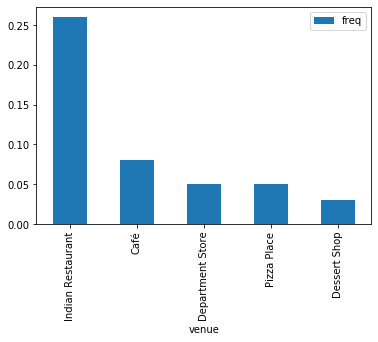

In [199]:
chennai_grouped_cluster_top['Adyar'].set_index('venue').plot(kind='bar')

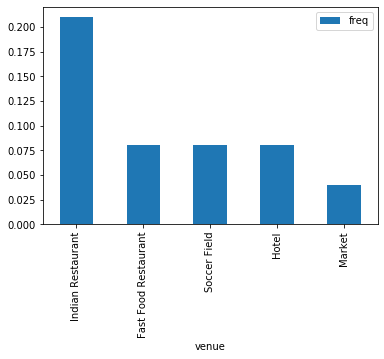

In [201]:
bangalore_grouped_cluster_top['Kundalahalli'].set_index('venue').plot(kind='bar')